# Install lib

In [1]:
!pip install zkyhaxpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Install Spark

In [2]:
!mkdir spark
!cd spark
!wget https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz -P /content/spark
!tar xf /content/spark/spark-3.3.1-bin-hadoop3.tgz

import findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

findspark.init()

--2022-11-07 04:00:17--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘/content/spark/spark-3.3.1-bin-hadoop3.tgz’

spark-3.3.1-bin-had 100%[===================>] 285.48M   224MB/s    in 1.3s    

2022-11-07 04:00:18 (224 MB/s) - ‘/content/spark/spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]



# Import lib

In [3]:
## for all ##
from zkyhaxpy import io_tools, pd_tools, np_tools, console_tools, timer_tools, json_tools, dict_tools, colab_tools
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Mount G-drive

In [5]:
colab_tools.mount_drive()

MessageError: ignored

# Connect to spark

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *


spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Trade data

## Download and unzip

In [7]:
#Download trade data
!wget 'https://fenixservices.fao.org/faostat/static/bulkdownloads/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip'
!unzip 'Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip'


--2022-11-07 04:12:02--  https://fenixservices.fao.org/faostat/static/bulkdownloads/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip
Resolving fenixservices.fao.org (fenixservices.fao.org)... 104.18.40.127, 172.64.147.129, 2606:4700:4400::6812:287f, ...
Connecting to fenixservices.fao.org (fenixservices.fao.org)|104.18.40.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404484537 (386M) [application/x-zip-compressed]
Saving to: ‘Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip’

Trade_DetailedTrade 100%[===================>] 385.75M   106MB/s    in 4.0s    

2022-11-07 04:12:06 (97.5 MB/s) - ‘Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip’ saved [404484537/404484537]

Archive:  Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip
  inflating: Trade_DetailedTradeMatrix_E_All_Data_(Normalized).csv  
  inflating: Trade_DetailedTradeMatrix_E_AreaCodes.csv  
  inflating: Trade_DetailedTradeMatrix_E_Flags.csv  
  inflating: Trade_DetailedTradeMa

## Read and prep

In [8]:
#Read file
sdf = spark.read.csv(
    'Trade_DetailedTradeMatrix_E_All_Data_(Normalized).csv',
    header='true')
sdf.show()

+---------------------+---------------------------+-------------------+--------------------+--------------------------+-----------------+---------+---------------+--------------------+------------+---------------+---------+----+--------+----------+----+
|Reporter Country Code|Reporter Country Code (M49)| Reporter Countries|Partner Country Code|Partner Country Code (M49)|Partner Countries|Item Code|Item Code (CPC)|                Item|Element Code|        Element|Year Code|Year|    Unit|     Value|Flag|
+---------------------+---------------------------+-------------------+--------------------+--------------------------+-----------------+---------+---------------+--------------------+------------+---------------+---------+----+--------+----------+----+
|                    2|                       '004|        Afghanistan|                   4|                      '012|          Algeria|      230|         '21424|Cashew nuts, shelled|        5910|Export Quantity|     2016|2016|  tonnes| 

In [19]:
#Read file
sdf = spark.read.csv(
    'Trade_DetailedTradeMatrix_E_All_Data_(Normalized).csv',
    header='true')

#Drop Columns
sdf = sdf.drop('Reporter Country Code (M49)',
    'Partner Country Code (M49)',
    'Item Code (CPC)',
    'Year Code',
    'Flag')

#Rename columns
sdf = sdf.withColumnRenamed('Reporter Country Code','report_country_cd') \
    .withColumnRenamed('Reporter Countries','report_country_nm') \
    .withColumnRenamed('Partner Country Code', 'partner_country_cd') \
    .withColumnRenamed('Partner Countries', 'partner_country_nm') \
    .withColumnRenamed('Item Code', 'item_cd') \
    .withColumnRenamed('Item', 'item_nm') \
    .withColumnRenamed('Element Code', 'element_cd') \
    .withColumnRenamed('Element', 'element_nm') \
    .withColumnRenamed('Year', 'year') \
    .withColumnRenamed('Unit', 'unit') \
    .withColumnRenamed('Value', 'value') \
    

#Update item name to lower case
sdf = sdf.withColumn('item_nm', lower(col('item_nm')))

#Add rice & wheat f
sdf = sdf.withColumn('rice_f', sdf.item_nm == 'rice, milled')
sdf = sdf.withColumn('wheat_f', sdf.item_nm == 'wheat')

#Filter only rice & wheat
sdf = sdf.filter((sdf.rice_f | sdf.wheat_f ))
sdf.show()

# df = sdf.toPandas()
# df.to_parquet(path_df_rice_wheat_trade)

# convert to pandas
path_df_rice_wheat_trade = '/content/drive/MyDrive/unbdh-multiverse-of-data/data/df_rice_wheat_trade.parquet'
if os.path.exists(path_df_rice_wheat_trade):
    df = pd.read_parquet(path_df_rice_wheat_trade)
else:
    df = sdf.toPandas()
    df.to_parquet(path_df_rice_wheat_trade)
df_trade = df.copy()

    
#Filter only rice from Thailand    
df_thailand_rice_export = df_trade[((df_trade.rice_f == 1) & df_trade.element_nm.isin(['Export Quantity', 'Export Value']) & (df_trade.report_country_nm == 'Thailand'))].copy()
df_thailand_rice_export['value'] = df_thailand_rice_export['value'].astype(np.float32)

#Aggregate to yearly
df_thai_rice_export_vol_yearly = df_thailand_rice_export.pivot_table(index=['year'], columns='element_nm', values='value', aggfunc='sum')
df_thai_rice_export_vol_yearly.columns = ['export_vol_mt', 'export_value_1000usd']
df_thai_rice_export_vol_yearly['export_price_usd_per_mt'] = df_thai_rice_export_vol_yearly.export_value_1000usd / df_thai_rice_export_vol_yearly.export_vol_mt * 1000
df_thai_rice_export_vol_yearly


+-----------------+--------------------+------------------+------------------+-------+------------+----------+---------------+----+--------+-----------+------+-------+
|report_country_cd|   report_country_nm|partner_country_cd|partner_country_nm|item_cd|     item_nm|element_cd|     element_nm|year|    unit|      value|rice_f|wheat_f|
+-----------------+--------------------+------------------+------------------+-------+------------+----------+---------------+----+--------+-----------+------+-------+
|                2|         Afghanistan|                 9|         Argentina|     31|rice, milled|      5610|Import Quantity|2016|  tonnes|       null|  true|  false|
|                2|         Afghanistan|                 9|         Argentina|     31|rice, milled|      5622|   Import Value|2016|1000 US$|       null|  true|  false|
|               53|               Benin|                 2|       Afghanistan|     31|rice, milled|      5610|Import Quantity|1996|  tonnes| 100.000000|  true| 

,export_vol_mt,export_value_1000usd,export_price_usd_per_mt
year,,,
1986,3328708.0,628708.0,188.874481
1987,3902461.0,801760.0,205.449844
1988,4584893.0,1204351.0,262.678131
1989,5868571.0,1660779.0,282.995453
1990,3451713.0,972311.0,281.689392
1991,3563846.0,1044162.0,292.987396
1992,4223847.0,1197991.0,283.625580
1993,4335265.0,1178916.0,271.936340
1994,4254303.0,1424569.0,334.853668


# Production

## Download and unzip

In [10]:
#Download production data
!wget 'https://fenixservices.fao.org/faostat/static/bulkdownloads/Production_Crops_Livestock_E_All_Data_(Normalized).zip'
!unzip 'Production_Crops_Livestock_E_All_Data_(Normalized).zip'


--2022-11-07 04:13:16--  https://fenixservices.fao.org/faostat/static/bulkdownloads/Production_Crops_Livestock_E_All_Data_(Normalized).zip
Resolving fenixservices.fao.org (fenixservices.fao.org)... 104.18.40.127, 172.64.147.129, 2606:4700:4400::6812:287f, ...
Connecting to fenixservices.fao.org (fenixservices.fao.org)|104.18.40.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30016063 (29M) [application/x-zip-compressed]
Saving to: ‘Production_Crops_Livestock_E_All_Data_(Normalized).zip’

Production_Crops_Li 100%[===================>]  28.62M  29.7MB/s    in 1.0s    

2022-11-07 04:13:18 (29.7 MB/s) - ‘Production_Crops_Livestock_E_All_Data_(Normalized).zip’ saved [30016063/30016063]

Archive:  Production_Crops_Livestock_E_All_Data_(Normalized).zip
  inflating: Production_Crops_Livestock_E_All_Data_(Normalized).csv  
  inflating: Production_Crops_Livestock_E_AreaCodes.csv  
  inflating: Production_Crops_Livestock_E_Flags.csv  
  inflating: Production_Crops_L

## Read data and prep

In [11]:
#Read file
sdf = spark.read.csv(
    'Production_Crops_Livestock_E_All_Data_(Normalized).csv',
    header='true')



#Drop Columns
sdf = sdf.drop('Area Code (M49)',    
    'Item Code (CPC)',
    'Year Code',
    'Flag')


#Rename columns
sdf = sdf \
    .withColumnRenamed('Area Code', 'country_cd') \
    .withColumnRenamed('Area', 'country_nm') \
    .withColumnRenamed('Item Code', 'item_cd') \
    .withColumnRenamed('Item', 'item_nm') \
    .withColumnRenamed('Element Code', 'element_cd') \
    .withColumnRenamed('Element', 'element_nm') \
    .withColumnRenamed('Year', 'year') \
    .withColumnRenamed('Unit', 'unit') \
    .withColumnRenamed('Value', 'value') \

    

#Update item name to lower case
sdf = sdf.withColumn('item_nm', lower(col('item_nm')))



#Add rice & wheat f
sdf = sdf.withColumn('rice_f', sdf.item_nm == 'rice')
sdf = sdf.withColumn('wheat_f', sdf.item_nm == 'wheat')

#Filter only rice & wheat
sdf = sdf.filter(
    (sdf.rice_f | sdf.wheat_f )
    )


# convert to pandas
path_df_rice_wheat_production = '/content/drive/MyDrive/unbdh-multiverse-of-data/data/df_rice_wheat_production.parquet'
if os.path.exists(path_df_rice_wheat_production):
    df = pd.read_parquet(path_df_rice_wheat_production)
else:
    df = sdf.toPandas()
    df.to_parquet(path_df_rice_wheat_production)
df_production = df.copy()        


In [18]:

    
#Filter only rice from Thailand    
df_thailand_rice_production = df_production[(df_production.rice_f == 1) & (df_production.element_nm == 'Production') & (df_production.country_nm == 'Thailand')].copy()
df_thailand_rice_production['value'] = df_thailand_rice_production['value'].astype(np.float32)

#Aggregate to yearly
df_thai_rice_production_vol_yearly = df_thailand_rice_production.groupby(['year']).agg(production_vol_mt = ('value', 'sum'))
df_thai_rice_production_vol_yearly


,production_vol_mt
year,
1961,10150000.0
1962,11250000.0
1963,12171000.0
1964,11600000.0
1965,11164000.0
1966,13500000.0
1967,11198000.0
1968,12410000.0
1969,13410000.0


# Join production & export

In [20]:
df_thai_rice_production_export_vol_yearly = df_thai_rice_export_vol_yearly.merge(df_thai_rice_production_vol_yearly, how='outer', left_index=True, right_index=True)
df_thai_rice_production_export_vol_yearly = df_thai_rice_production_export_vol_yearly.dropna().copy()

df_thai_rice_production_export_vol_yearly['production_vol_mt_lag_1'] = df_thai_rice_production_export_vol_yearly.production_vol_mt.shift(1)
df_thai_rice_production_export_vol_yearly['export_ratio'] = df_thai_rice_production_export_vol_yearly.export_vol_mt /  df_thai_rice_production_export_vol_yearly.production_vol_mt
df_thai_rice_production_export_vol_yearly['export_ratio_lag_1'] = df_thai_rice_production_export_vol_yearly.export_vol_mt /  df_thai_rice_production_export_vol_yearly.production_vol_mt_lag_1
df_thai_rice_production_export_vol_yearly

,export_vol_mt,export_value_1000usd,export_price_usd_per_mt,production_vol_mt,production_vol_mt_lag_1,export_ratio,export_ratio_lag_1
year,,,,,,,
1986,3328708.0,628708.0,188.874481,18868160.0,NaN,0.176419,NaN
1987,3902461.0,801760.0,205.449844,18428272.0,18868160.0,0.211765,0.206828
1988,4584893.0,1204351.0,262.678131,21262896.0,18428272.0,0.215629,0.248797
1989,5868571.0,1660779.0,282.995453,20601008.0,21262896.0,0.284868,0.276001
1990,3451713.0,972311.0,281.689392,17193216.0,20601008.0,0.200760,0.167551
1991,3563846.0,1044162.0,292.987396,20400000.0,17193216.0,0.174698,0.207282
1992,4223847.0,1197991.0,283.625580,19917300.0,20400000.0,0.212069,0.207051
1993,4335265.0,1178916.0,271.936340,18447260.0,19917300.0,0.235009,0.217663
1994,4254303.0,1424569.0,334.853668,21110714.0,18447260.0,0.201523,0.230620


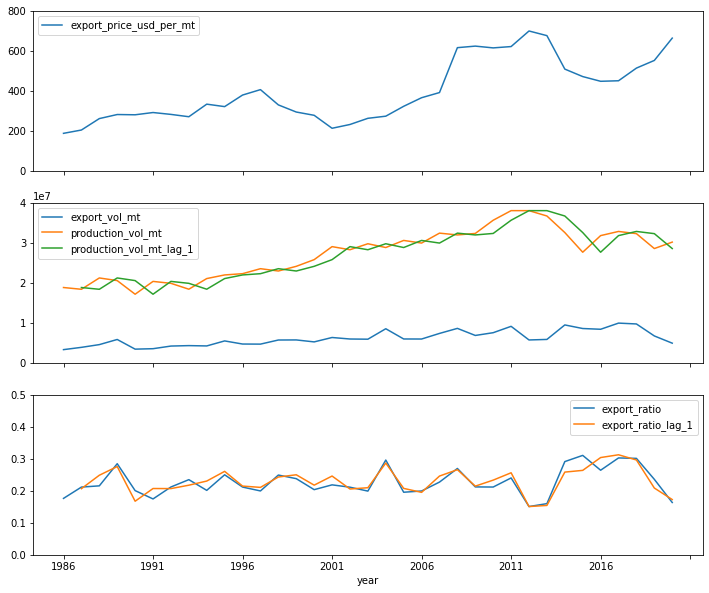

In [22]:
fig, axs = plt.subplots(3, figsize=(12, 10), sharex=True)

df_thai_rice_production_export_vol_yearly.loc[:, ['export_price_usd_per_mt']].plot(ax=axs[0])
axs[0].set_ylim(0, 800)

df_thai_rice_production_export_vol_yearly.loc[:, ['export_vol_mt', 'production_vol_mt', 'production_vol_mt_lag_1']].plot(ax=axs[1])
axs[1].set_ylim(0, 4e7)

df_thai_rice_production_export_vol_yearly.loc[:, ['export_ratio', 'export_ratio_lag_1']].plot(ax=axs[2])
axs[2].set_ylim(0, 0.5)
plt.show()